In [53]:
import numpy as np
import os
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing import image
from sklearn.model_selection import train_test_split
from PIL import Image  # PIL is used to load the image
import matplotlib.pyplot as plt
import cv2
from tensorflow.keras.regularizers import l2

In [54]:
tf.keras.mixed_precision.set_global_policy('float32')
print(f"Using mixed precision: {tf.keras.mixed_precision.global_policy()}")

Using mixed precision: <Policy "float32">


In [55]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

print(tf.config.list_physical_devices('GPU'))


[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 9261331001292641491
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 10057940992
locality {
  bus_id: 1
  links {
  }
}
incarnation: 8875403454023610153
physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 3060, pci bus id: 0000:01:00.0, compute capability: 8.6"
xla_global_id: 416903419
]
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [56]:
# Check if TensorFlow can access the GPU
physical_devices = tf.config.list_physical_devices('GPU')
if physical_devices:
    print(f"TensorFlow is using GPU: {physical_devices[0]}")
else:
    print("No GPU available.")

TensorFlow is using GPU: PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


In [57]:
base_dir = r"C:\Users\Coli\Downloads\Final Data\Final Data"

In [58]:
styles = os.listdir(base_dir)
print(styles) # Print the list of styles to verify

['Art Nouveau', 'Baroque', 'Color Field Painting', 'Cubism', 'Expressionism', 'Fauvism', 'Impressionism', 'Minimalism', 'Naive Art Primitivism', 'Pop Art', 'Realism', 'Renaissance', 'Rococo', 'Romanticism', 'Symbolism', 'Ukiyo_e']


In [59]:
image_height = 224
image_width = 224
batch_size = 32
seed = 42 # For reproducibility

In [60]:
print("Loading training data...")
train_ds = tf.keras.utils.image_dataset_from_directory(
    base_dir,
    labels='inferred',
    label_mode='categorical', # Your labels are one-hot encoded
    image_size=(image_height, image_width),
    interpolation='bicubic', # or 'bilinear', 'nearest'
    batch_size=batch_size,
    shuffle=True, # Shuffle training data
    seed=seed,
    validation_split=0.3, # 30% for validation/test combined
    subset='training'
)

print("Loading validation data...")
val_ds = tf.keras.utils.image_dataset_from_directory(
    base_dir,
    labels='inferred',
    label_mode='categorical',
    image_size=(image_height, image_width),
    interpolation='bicubic',
    batch_size=batch_size,
    shuffle=False, # No need to shuffle validation data
    seed=seed,
    validation_split=0.3,
    subset='validation'
)

Loading training data...
Found 14750 files belonging to 16 classes.
Using 10325 files for training.
Loading validation data...
Found 14750 files belonging to 16 classes.
Using 4425 files for validation.


In [61]:
print(f"Detected class names: {train_ds.class_names}")


Detected class names: ['Art Nouveau', 'Baroque', 'Color Field Painting', 'Cubism', 'Expressionism', 'Fauvism', 'Impressionism', 'Minimalism', 'Naive Art Primitivism', 'Pop Art', 'Realism', 'Renaissance', 'Rococo', 'Romanticism', 'Symbolism', 'Ukiyo_e']


In [62]:
all_image_paths = []
all_labels = []

In [67]:
grouped_styles = [
    'Art Nouveau', 'Baroque', 'Color Field Painting', 'Cubism', 'Expressionism', 'Fauvism', 
    'Impressionism', 'Minimalism', 'Naive Art Primitivism', 'Pop Art', 'Realism', 'Renaissance', 
    'Rococo', 'Romanticism', 'Symbolism', 'Ukiyo_e'
]

In [68]:
for i, style_name in enumerate(grouped_styles):
    style_dir = os.path.join(base_dir, style_name)
    if not os.path.exists(style_dir):
        print(f"Warning: Directory for grouped style '{style_name}' not found at {style_dir}")
        continue
    for image_name in os.listdir(style_dir):
        image_path = os.path.join(style_dir, image_name)
        all_image_paths.append(image_path)
        all_labels.append(i)

In [69]:
all_image_paths = np.array(all_image_paths)
all_labels = np.array(all_labels)

# Perform stratified split
X_train_paths, X_temp_paths, y_train_labels, y_temp_labels = train_test_split(
    all_image_paths, all_labels, test_size=0.3, random_state=seed, stratify=all_labels
)
X_val_paths, X_test_paths, y_val_labels, y_test_labels = train_test_split(
    X_temp_paths, y_temp_labels, test_size=0.5, random_state=seed, stratify=y_temp_labels
)


# # First, split into 70% training and 30% temporary (for validation and test)
# X_train, X_temp, y_train, y_temp = train_test_split(images, labels, test_size=0.3, random_state=42, stratify=labels)

# # Now, split the 30% temporary into 15% validation and 15% test
# # Since X_temp is 30% of the original data, 0.5 of X_temp will be 15% of the original data
# X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

In [70]:
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers

In [71]:
def apply_random_saturation(image, factor=0.1):
    return tf.image.random_saturation(image, lower=1-factor, upper=1+factor)


data_augmentation_layers = tf.keras.Sequential([
    layers.RandomFlip("horizontal"), # Changed from "horizontal_and_vertical"
    layers.RandomRotation(0.02),
    layers.RandomTranslation(height_factor=0.04, width_factor=0.04, fill_mode='nearest'),
    layers.RandomZoom(0.08),
    
    
    layers.RandomContrast(0.1),  # Custom layer for random brightness
    layers.Lambda(lambda x:apply_random_saturation(x, factor=0.05), name = 'manual_random_saturation'),  # Apply random saturation

    layers.GaussianNoise(0.01),



    tf.keras.layers.Lambda(lambda x: tf.clip_by_value(x, 0.0, 1.0))
], name='data_augmentation')

In [72]:
# print(f"Training set: {len(X_train)} samples ({len(X_train)/len(images)*100:.1f}%)")
# print(f"Validation set: {len(X_val)} samples ({len(X_val)/len(images)*100:.1f}%)")
# print(f"Test set: {len(X_test)} samples ({len(X_test)/len(images)*100:.1f}%)")

def preprocess_image(image_path, label):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3) # or decode_png
    img = tf.image.resize(img, [image_height, image_width])
    img = tf.cast(img, tf.float32) / 255.0 # Normalize
    num_classes = len(grouped_styles) # Use the count of your grouped styles
    label = tf.one_hot(label, num_classes) # One-hot encode labels
    return img, label

In [73]:
# y_train_np = np.array(y_train)
# unique_elements, counts = np.unique(y_train_np, return_counts=True)
# print("Counts of each style in y_train:")
# for element, count in zip(unique_elements, counts):
#     print(f"{element}: {count}")

# y_val_np = np.array(y_val)
# unique_elements, counts = np.unique(y_val_np, return_counts=True)
# print("Counts of each style in y_val:")
# for element, count in zip(unique_elements, counts):
#     print(f"{element}: {count}")

train_ds = tf.data.Dataset.from_tensor_slices((X_train_paths, y_train_labels))
train_ds = train_ds.map(preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
train_ds = train_ds.shuffle(buffer_size=1024).batch(batch_size).prefetch(tf.data.AUTOTUNE)

val_ds = tf.data.Dataset.from_tensor_slices((X_val_paths, y_val_labels))
val_ds = val_ds.map(preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
val_ds = val_ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)

test_ds = tf.data.Dataset.from_tensor_slices((X_test_paths, y_test_labels))
test_ds = test_ds.map(preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
test_ds = test_ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)

In [74]:
# Check number of rows per class per dataset
print(f"Number of training samples: {len(X_train_paths)}")
print(f"Number of validation samples: {len(X_val_paths)}")
print(f"Number of test samples: {len(X_test_paths)}")

Number of training samples: 27777
Number of validation samples: 5952
Number of test samples: 5953


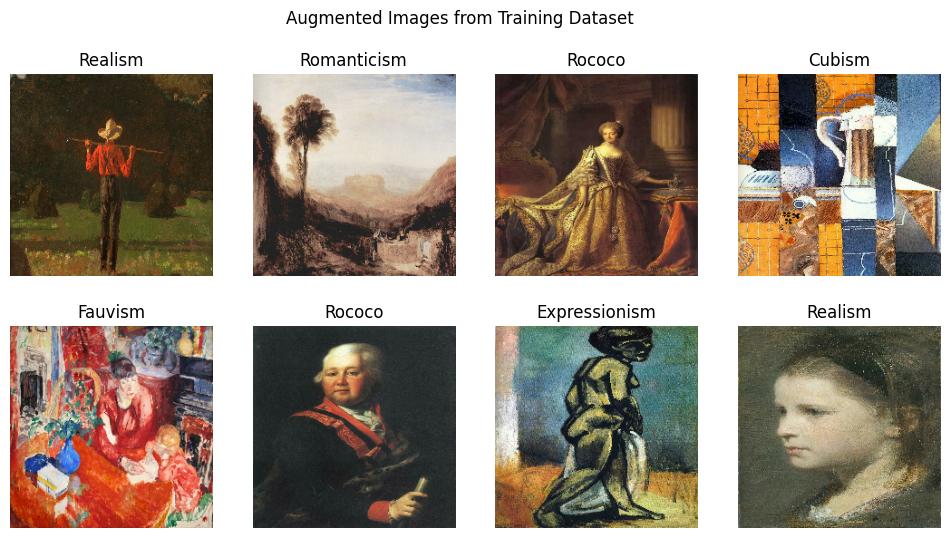

In [77]:
# Display a batch of augmented images from the training dataset
for images, labels in train_ds.take(1):
    plt.figure(figsize=(12, 6))
    for i in range(min(8, images.shape[0])):
        ax = plt.subplot(2, 4, i + 1)
        plt.imshow(images[i].numpy())
        label_idx = np.argmax(labels[i].numpy())
        plt.title(f"{grouped_styles[label_idx]}")
        plt.axis("off")
    plt.suptitle("Augmented Images from Training Dataset")
    plt.show()

In [78]:
from sklearn.utils import class_weight # For calculating class weights

class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train_labels),
    y=y_train_labels
)
class_weights_dict = dict(enumerate(class_weights))

print("Class weights calculated:")
for i, weight in class_weights_dict.items():
    print(f"  Class {grouped_styles[i]} (Index {i}): Weight {weight:.4f}")

Class weights calculated:
  Class Art Nouveau (Index 0): Weight 1.3293
  Class Baroque (Index 1): Weight 0.9023
  Class Color Field Painting (Index 2): Weight 1.3468
  Class Cubism (Index 3): Weight 0.9166
  Class Expressionism (Index 4): Weight 0.9234
  Class Fauvism (Index 5): Weight 0.9085
  Class Impressionism (Index 6): Weight 0.9014
  Class Minimalism (Index 7): Weight 0.9047
  Class Naive Art Primitivism (Index 8): Weight 2.7426
  Class Pop Art (Index 9): Weight 1.3691
  Class Realism (Index 10): Weight 0.8659
  Class Renaissance (Index 11): Weight 0.8812
  Class Rococo (Index 12): Weight 0.8654
  Class Romanticism (Index 13): Weight 0.9047
  Class Symbolism (Index 14): Weight 0.9056
  Class Ukiyo_e (Index 15): Weight 0.8637


In [79]:
# Check how many for each class are in each dataset. Define each class from its original label
unique_train_labels, train_counts = np.unique(y_train_labels, return_counts=True)
print("Training set class distribution:")
for label, count in zip(unique_train_labels, train_counts):
    print(f"Class {label} ({grouped_styles[label]}): {count} samples")

Training set class distribution:
Class 0 (Art Nouveau): 1306 samples
Class 1 (Baroque): 1924 samples
Class 2 (Color Field Painting): 1289 samples
Class 3 (Cubism): 1894 samples
Class 4 (Expressionism): 1880 samples
Class 5 (Fauvism): 1911 samples
Class 6 (Impressionism): 1926 samples
Class 7 (Minimalism): 1919 samples
Class 8 (Naive Art Primitivism): 633 samples
Class 9 (Pop Art): 1268 samples
Class 10 (Realism): 2005 samples
Class 11 (Renaissance): 1970 samples
Class 12 (Rococo): 2006 samples
Class 13 (Romanticism): 1919 samples
Class 14 (Symbolism): 1917 samples
Class 15 (Ukiyo_e): 2010 samples


In [80]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, Activation, GlobalAveragePooling2D
from tensorflow.keras.regularizers import l2

## VGG-13




In [89]:
vgg13 = Sequential([
  # Block 1 (64 filters)
  Conv2D(64, (3, 3), padding='same', kernel_regularizer=l2(1e-3), input_shape=(224,224, 3)),
  BatchNormalization(),
  Activation('relu'),
  Conv2D(64, (3, 3), padding='same', kernel_regularizer=l2(1e-3)),
  BatchNormalization(),
  Activation('relu'),
  MaxPooling2D((2, 2), strides=(2,2)),

  # Block 2 (128 filters)
  Conv2D(128, (3, 3), padding='same', kernel_regularizer=l2(1e-3)),
  BatchNormalization(),
  Activation('relu'),
  Conv2D(128, (3, 3), padding='same', kernel_regularizer=l2(1e-3)),
  BatchNormalization(),
  Activation('relu'),
  MaxPooling2D((2, 2), strides=(2,2)),

  # Block 3 (256 filters)
  Conv2D(256, (3, 3), padding='same', kernel_regularizer=l2(1e-3)),
  BatchNormalization(),
  Activation('relu'),
  Conv2D(256, (3, 3), padding='same', kernel_regularizer=l2(1e-3)),
  BatchNormalization(),
  Activation('relu'),
  MaxPooling2D((2, 2), strides=(2,2)),

  # Block 4 (512 filters)
  Conv2D(512, (3, 3), padding='same', kernel_regularizer=l2(1e-3)),
  BatchNormalization(),
  Activation('relu'),
  Conv2D(512, (3, 3), padding='same', kernel_regularizer=l2(1e-3)),
  BatchNormalization(),
  Activation('relu'),
  MaxPooling2D((2, 2), strides=(2,2)),

  # Block 5 (optional, 512 filters, if image size allows further pooling)
  # For 128x128, a 5th pooling layer would lead to 4x4 or 2x2.
  Conv2D(512, (3, 3), padding='same', kernel_regularizer=l2(1e-3)),
  BatchNormalization(), Activation('relu'),
  Conv2D(512, (3, 3), padding='same', kernel_regularizer=l2(1e-3)),
  BatchNormalization(), Activation('relu'),
  MaxPooling2D((2, 2), strides=(2,2)),

  # Classification Head (modified for common practice and Grad-CAM)
  GlobalAveragePooling2D(),
  BatchNormalization(), # After pooling
  Dense(512, activation='relu', kernel_regularizer=l2(1e-3)),
  BatchNormalization(),
  Dropout(0.3),
  Dense(512, activation='relu', kernel_regularizer=l2(1e-3)),
  BatchNormalization(), # Added this
  Dropout(0.3),
  Dense(16, activation='softmax')
])

In [90]:
vgg13.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 64)      1792      
                                                                 
 batch_normalization (BatchN  (None, 224, 224, 64)     256       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 224, 224, 64)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 224, 224, 64)      36928     
                                                                 
 batch_normalization_1 (Batc  (None, 224, 224, 64)     256       
 hNormalization)                                                 
                                                                 
 activation_1 (Activation)   (None, 224, 224, 64)      0

In [91]:
from tensorflow.keras.callbacks import EarlyStopping


In [92]:
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
base_optimizer = tf.keras.mixed_precision.LossScaleOptimizer(optimizer)

vgg13.compile(
    optimizer=base_optimizer,
    loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.1),
    metrics=['accuracy']
)


In [93]:
early_stop = EarlyStopping(
    monitor='val_loss', 
    patience=20,         
    restore_best_weights=True,
    verbose=1,
    min_delta=0.0001,      
)

In [94]:
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss', factor=0.5, patience=10, min_lr=1e-7, verbose=1, min_delta=0.0001)

In [95]:
# Clear any previous Keras sessions
tf.keras.backend.clear_session()

In [96]:
# Fit the model
history_vgg13 = vgg13.fit(
    train_ds,
    validation_data=val_ds,
    epochs=100,
    callbacks=[early_stop, reduce_lr],
)


Epoch 1/100


869/869 [==============================] - 474s 541ms/step - loss: 6.1199 - accuracy: 0.2813 - val_loss: 6.0115 - val_accuracy: 0.3325 - lr: 1.0000e-04
Epoch 2/100
869/869 [==============================] - 472s 541ms/step - loss: 5.5045 - accuracy: 0.3633 - val_loss: 5.2864 - val_accuracy: 0.3884 - lr: 1.0000e-04
Epoch 3/100
869/869 [==============================] - 477s 547ms/step - loss: 4.9958 - accuracy: 0.4186 - val_loss: 5.2874 - val_accuracy: 0.3659 - lr: 1.0000e-04
Epoch 4/100
869/869 [==============================] - 471s 540ms/step - loss: 4.4946 - accuracy: 0.4640 - val_loss: 4.7808 - val_accuracy: 0.3735 - lr: 1.0000e-04
Epoch 5/100
869/869 [==============================] - 489s 561ms/step - loss: 4.0266 - accuracy: 0.5021 - val_loss: 4.1129 - val_accuracy: 0.4444 - lr: 1.0000e-04
Epoch 6/100
869/869 [==============================] - 496s 568ms/step - loss: 3.6177 - accuracy: 0.5377 - val_loss: 3.9469 - val_accuracy: 0.3960 - lr: 1.0000e-04
Epoch 7/100
869/869 [=======

In [97]:
# Normal
# print(history.history['accuracy'][-1])
# print(history.history['val_accuracy'][-1])

# AlexNet
print("Final training accuracy:", history_vgg13.history['accuracy'][-1])
print("Final validation accuracy:", history_vgg13.history['val_accuracy'][-1])

Final training accuracy: 0.9988839626312256
Final validation accuracy: 0.8886088728904724


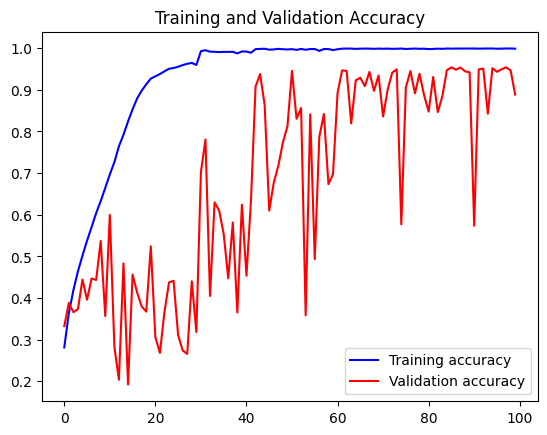

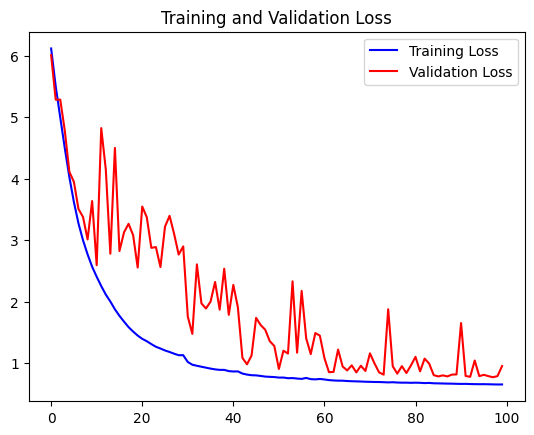

In [98]:
# Normal
# acc = history.history['accuracy']
# val_acc = history.history['val_accuracy']
# loss = history.history['loss']
# val_loss = history.history['val_loss']

# epochs = range(len(acc))

# plt.plot(epochs, acc, 'b', label='Training accuracy')
# plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
# plt.title('Training and Validation Accuracy')
# plt.legend()

# plt.figure()

# plt.plot(epochs, loss, 'b', label='Training Loss')
# plt.plot(epochs, val_loss, 'r', label='Validation Loss')
# plt.title('Training and Validation Loss')
# plt.legend()

# plt.show()

# AlexNet 
acc = history_vgg13.history['accuracy']
val_acc = history_vgg13.history['val_accuracy']
loss = history_vgg13.history['loss']
val_loss = history_vgg13.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.show()

In [99]:
vgg13.evaluate(test_ds)

187/187 [==============================] - 26s 137ms/step - loss: 0.9657 - accuracy: 0.8806


[0.9657422304153442, 0.8805643916130066]

Selected random image at index 5655
True class: Baroque
1/1 [==============================] - 0s 334ms/step

Top 3 predictions for the sample image:
1. Baroque: 0.917
2. Rococo: 0.008
3. Naive Art Primitivism: 0.008


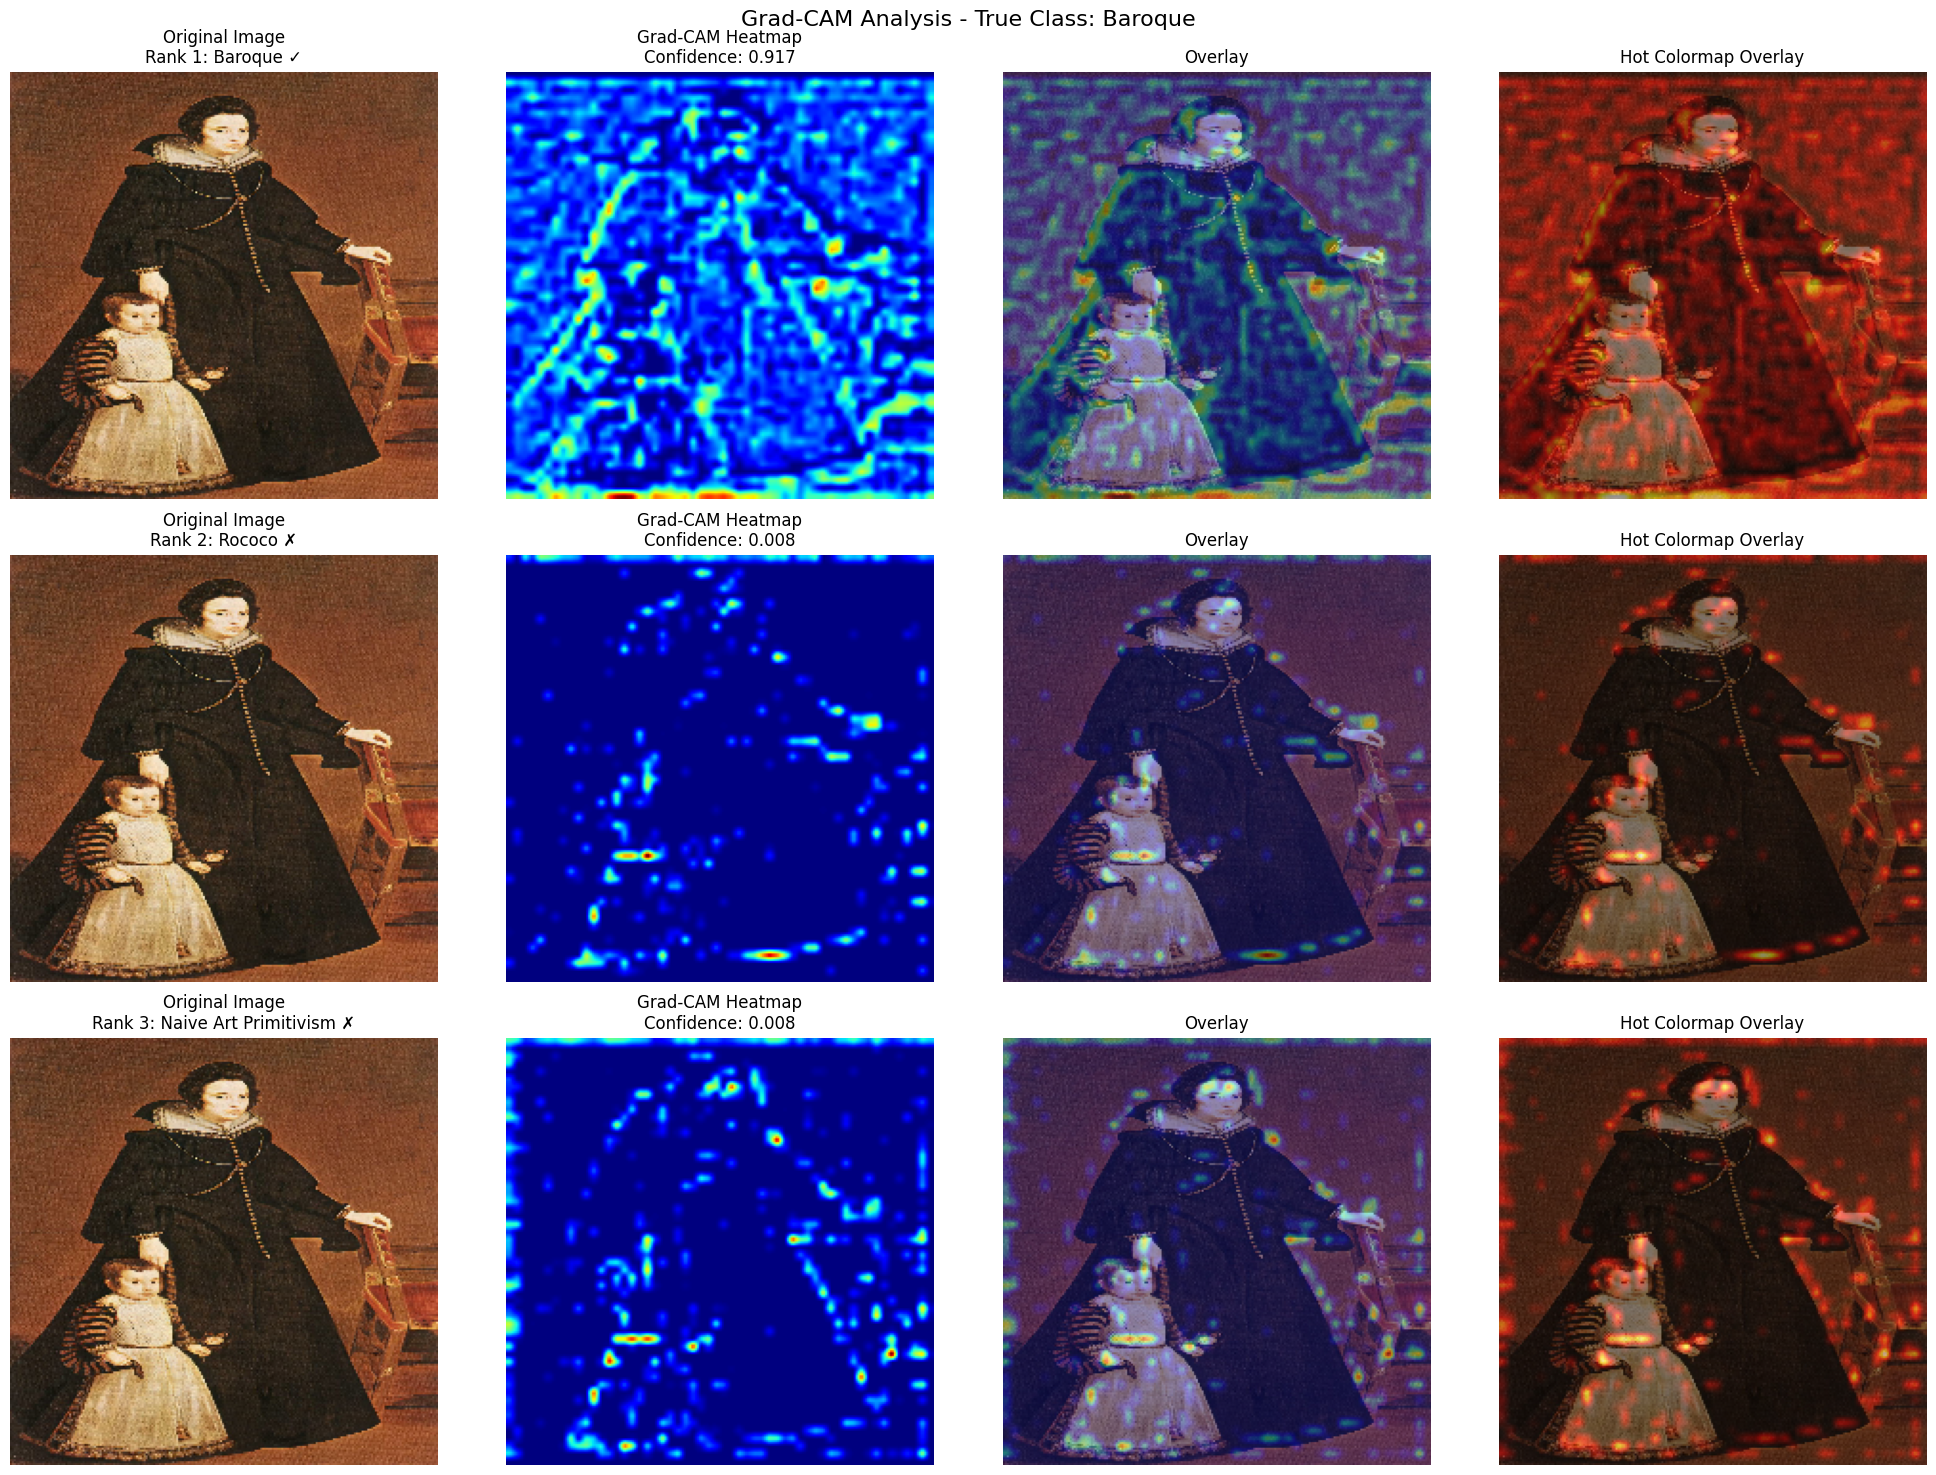

In [100]:
import numpy as np

# Select a random image from the test set
random_index = np.random.randint(0, len(X_test_paths))
sample_image_path = X_test_paths[random_index]
true_label = y_test_labels[random_index]

print(f"Selected random image at index {random_index}")
print(f"True class: {grouped_styles[true_label]}")

# Get the top 3 predicted classes for the sample image
sample_predictions = vgg13.predict(tf.expand_dims(tf.cast(tf.image.resize(tf.image.decode_jpeg(tf.io.read_file(sample_image_path), channels=3), [224, 224]), tf.float32) / 255.0, axis=0))
top3_indices = np.argsort(sample_predictions[0])[-3:][::-1]  # Get top 3 in descending order
top3_probs = sample_predictions[0][top3_indices]

print(f"\nTop 3 predictions for the sample image:")
for i, (idx, prob) in enumerate(zip(top3_indices, top3_probs)):
    print(f"{i+1}. {grouped_styles[idx]}: {prob:.3f}")

# Define Grad-CAM function
def get_gradcam(model, img_array, layer_name, class_idx=None):
    # Create a model that maps the input image to the activations of the last conv layer
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(layer_name).output, model.output]
    )
    
    # Compute the gradient of the top predicted class for our input image
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        if class_idx is None:
            class_idx = tf.argmax(predictions[0])
        loss = predictions[:, class_idx]
    
    # Extract the gradients of the top predicted class with regard to the output feature map
    output = conv_outputs[0]
    grads = tape.gradient(loss, conv_outputs)[0]
    
    # Pool the gradients across the channels
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1))
    
    # Weight the feature map by the pooled gradients
    heatmap = tf.reduce_sum(tf.multiply(pooled_grads, output), axis=-1)
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    
    # Resize heatmap to match input image size
    heatmap = tf.image.resize(tf.expand_dims(heatmap, -1), [224, 224])
    heatmap = tf.squeeze(heatmap)
    
    return heatmap.numpy()

# Visualize Grad-CAM for each of the top 3 classes
def visualize_gradcam_top3(model, image_path, top3_classes, top3_probs, true_class, layer_name='conv2d_4'):
    # Load and preprocess the image
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, [224, 224])
    img_array = tf.cast(img, tf.float32) / 255.0
    img_array = tf.expand_dims(img_array, axis=0)
    
    # Create visualization for top 3 classes
    fig, axes = plt.subplots(3, 4, figsize=(20, 15))
    
    for i, (class_idx, prob) in enumerate(zip(top3_classes, top3_probs)):
        # Generate Grad-CAM heatmap for specific class
        heatmap = get_gradcam(model, img_array, layer_name, class_idx=class_idx)
        
        # Original image
        axes[i, 0].imshow(img_array[0])
        correct = "✓" if class_idx == true_class else "✗"
        axes[i, 0].set_title(f'Original Image\nRank {i+1}: {grouped_styles[class_idx]} {correct}')
        axes[i, 0].axis('off')
        
        # Heatmap
        axes[i, 1].imshow(heatmap, cmap='jet')
        axes[i, 1].set_title(f'Grad-CAM Heatmap\nConfidence: {prob:.3f}')
        axes[i, 1].axis('off')
        
        # Overlay
        axes[i, 2].imshow(img_array[0])
        axes[i, 2].imshow(heatmap, cmap='jet', alpha=0.4)
        axes[i, 2].set_title('Overlay')
        axes[i, 2].axis('off')
        
        # Heatmap with different colormap for better contrast
        axes[i, 3].imshow(img_array[0])
        axes[i, 3].imshow(heatmap, cmap='hot', alpha=0.5)
        axes[i, 3].set_title('Hot Colormap Overlay')
        axes[i, 3].axis('off')
    
    plt.suptitle(f'Grad-CAM Analysis - True Class: {grouped_styles[true_class]}', fontsize=16)
    plt.tight_layout()
    plt.show()

# Use the correct layer name from AlexNet (last conv layer)
visualize_gradcam_top3(vgg13, sample_image_path, top3_indices, top3_probs, true_label, layer_name='conv2d_4')


In [101]:
# Print Classification Report. Print which number represents which art style
from sklearn.metrics import classification_report
y_pred = vgg13.predict(test_ds)
y_pred_classes = np.argmax(y_pred, axis=1)
y_test_classes = y_test_labels
print(classification_report(y_test_classes, y_pred_classes, target_names=styles))

187/187 [==============================] - 26s 136ms/step
                       precision    recall  f1-score   support

          Art Nouveau       0.98      0.86      0.91       280
              Baroque       0.85      0.99      0.91       412
 Color Field Painting       0.97      0.95      0.96       276
               Cubism       0.99      0.91      0.95       406
        Expressionism       0.94      0.94      0.94       402
              Fauvism       0.87      0.97      0.92       409
        Impressionism       0.99      0.52      0.68       413
           Minimalism       0.94      0.97      0.95       412
Naive Art Primitivism       0.44      0.21      0.28       135
              Pop Art       0.96      0.86      0.91       272
              Realism       0.99      0.85      0.91       430
          Renaissance       0.85      0.96      0.90       422
               Rococo       0.62      0.98      0.76       430
          Romanticism       1.00      0.73      0.84       

In [102]:
vgg13.save('model.keras')

converter = tf.lite.TFLiteConverter.from_keras_model(vgg13)
tflite_model = converter.convert()

with open("model.tflite", "wb") as f:
    f.write(tflite_model)

INFO:tensorflow:Assets written to: C:\Users\Coli\AppData\Local\Temp\tmpn1dboeum\assets


INFO:tensorflow:Assets written to: C:\Users\Coli\AppData\Local\Temp\tmpn1dboeum\assets
